# Demo 4: Breaking Down the `forward()` Method

Neural networks process data through a sequence of transformations, but when you use `nn.Sequential`, those transformations happen invisibly. What if you could control exactly how your data flows—adding custom logic, branching paths, or conditional operations that `nn.Sequential` can't express?

> **Overview**: Move from using `nn.Sequential` _(recommended by default)_ to subclassing `nn.Module` _(full control and flexibility)_. You'll learn to implement the `forward()` method yourself, understanding exactly how data flows through your network and why this unlocks the ability to build any architecture you can imagine.
> 
> **Scenario**: You're supporting an HR team that uses a neural network to predict employee attrition risk. The model works with `nn.Sequential`, but the team wants to understand exactly how employee features transform into predictions, and they're considering architectural changes that `nn.Sequential` can't handle. By learning to implement the forward pass yourself, you'll gain the foundation to build any custom architecture.
> 
> **Goal**: Understand best practices in subclassing `nn.Module`, implement the `forward()` method, and discover how `model(x)` orchestrates the entire forward pass.
> 
> **Tools**: Python, PyTorch, NumPy, Pandas, Matplotlib

## Step 1: Setup

Let's start by importing our libraries and setting up our environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory for visualizations
output_dir = 'assets/demo4'
os.makedirs(output_dir, exist_ok=True)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Setup complete!\n")

Using device: cuda
Setup complete!



## Step 2: Load and prepare the data

We'll use the [Redsmoothy/HR_Attrition](https://huggingface.co/datasets/Redsmoothy/HR_Attrition) dataset from Hugging Face, which contains employment data for 1,470 employees with features like age, income, work-life balance, and years at the company.

For preprocessing, we'll:
1. _Load the dataset_
2. _Select 10 key numeric features_ that are most relevant for predicting attrition
3. _Encode categorical variables_ (like OverTime: Yes→1, No→0)
4. _Normalize features_ to [0, 1] range for neural network training
5. _Encode the target_ (Attrition: Yes→1, No→0)
6. _Convert to PyTorch tensors_

**IMPORTANT: Feel free to skip this section to focus on the forward pass itself**. Just know that we end up with a dataset where each employee is represented by 10 numeric features, and we're predicting a binary label indicating whether they're likely to leave the company.

In [2]:
# 1. Load the dataset
dataset = load_dataset('Redsmoothy/HR_Attrition', split='train')
print(f"✓ Dataset loaded: {len(dataset)} employees found\n")

# 2. Convert to pandas for easier preprocessing
df = pd.DataFrame(dataset)

# Display first few rows
print("Sample of raw data:")
print(df[['Age', 'MonthlyIncome', 'TotalWorkingYears', 'OverTime', 'Attrition']].head())
print(f"\nTarget distribution: {df['Attrition'].value_counts().to_dict()}")

README.md:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

HR_Attrition.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1470 [00:00<?, ? examples/s]

✓ Dataset loaded: 1470 employees found

Sample of raw data:
   Age  MonthlyIncome  TotalWorkingYears OverTime Attrition
0   41           5993                  8      Yes       Yes
1   49           5130                 10       No        No
2   37           2090                  7      Yes       Yes
3   33           2909                  8      Yes        No
4   27           3468                  6       No        No

Target distribution: {'No': 1233, 'Yes': 237}


In [3]:
# 3. Select 10 key numeric features for predicting attrition
feature_columns = [
    'Age',                     # Career stage indicator
    'DistanceFromHome',        # Commute burden
    'MonthlyIncome',           # Compensation level
    'TotalWorkingYears',       # Experience level
    'YearsAtCompany',          # Tenure
    'YearsInCurrentRole',      # Role stagnation indicator
    'YearsSinceLastPromotion', # Career growth indicator
    'YearsWithCurrManager',    # Management relationship
    'WorkLifeBalance',         # Work-life satisfaction (1-4 rating)
    'OverTime'                 # Work intensity (will encode as binary)
]

# Create feature dataframe
features_df = df[feature_columns].copy()

# 4. Encode OverTime: Yes→1, No→0
features_df['OverTime'] = (features_df['OverTime'] == 'Yes').astype(int)

print("✓ Selected 10 key features for the model")
print("\nFeature statistics:")
print(features_df.describe())

✓ Selected 10 key features for the model

Feature statistics:
               Age  DistanceFromHome  MonthlyIncome  TotalWorkingYears  \
count  1470.000000       1470.000000    1470.000000        1470.000000   
mean     36.923810          9.192517    6502.931293          11.279592   
std       9.135373          8.106864    4707.956783           7.780782   
min      18.000000          1.000000    1009.000000           0.000000   
25%      30.000000          2.000000    2911.000000           6.000000   
50%      36.000000          7.000000    4919.000000          10.000000   
75%      43.000000         14.000000    8379.000000          15.000000   
max      60.000000         29.000000   19999.000000          40.000000   

       YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
count     1470.000000         1470.000000              1470.000000   
mean         7.008163            4.229252                 2.187755   
std          6.126525            3.623137                 3.2

> **On the feature selection**: In a real deployment, you'd experiment with different feature combinations, engineer interaction terms, or use domain expertise from HR. But these 10 features—covering compensation, tenure, work-life balance, and career growth—give us a solid baseline that's interpretable and captures the main drivers of attrition.

In [4]:
# 5. Normalize features to [0, 1] range
# Store min/max for each feature for normalization
feature_mins = features_df.min()
feature_maxs = features_df.max()

# Normalize each feature
features_normalized = (features_df - feature_mins) / (feature_maxs - feature_mins + 1e-8)

print("✓ Features normalized to [0, 1] range")
print("\nNormalized feature ranges:")
print(f"Min: {features_normalized.min().max():.4f}")
print(f"Max: {features_normalized.max().min():.4f}")

✓ Features normalized to [0, 1] range

Normalized feature ranges:
Min: 0.0000
Max: 1.0000


> **Why normalize?** Without normalization, high-magnitude features like `MonthlyIncome` (thousands) would dominate low-magnitude ones like `WorkLifeBalance` (1-4 scale) during training. 
> 
> Scaling everything to [0,1] puts all features on equal footing so the network can learn their relative importance fairly.

In [5]:
# 6. Encode target variable: Attrition (Yes→1, No→0)
target = (df['Attrition'] == 'Yes').astype(int).values

print(f"✓ Target encoded: Yes→1 (will leave), No→0 (will stay)")
print(f"\nAttrition rate: {target.mean():.1%} of employees left")

✓ Target encoded: Yes→1 (will leave), No→0 (will stay)

Attrition rate: 16.1% of employees left


> **Class imbalance alert**: With only 16.1% attrition, our dataset is imbalanced, which is typical for retention problems where most employees stay. Production models would address this, but for learning forward pass mechanics, we'll proceed as-is.

In [6]:
# 7. Convert to PyTorch tensors
X = torch.FloatTensor(features_normalized.values)
y = torch.FloatTensor(target).unsqueeze(1)  # Add dimension: (N,) → (N, 1) to match the network's output dimensions

print(f"✓ Converted to PyTorch tensors")
print(f"\nFinal shapes:")
print(f"  Features (X): {X.shape} → {X.shape[0]} employees, {X.shape[1]} features each")
print(f"  Target (y):   {y.shape} → {y.shape[0]} labels (1=will leave, 0=will stay)")
print(f"\nDataset ready for training!")

✓ Converted to PyTorch tensors

Final shapes:
  Features (X): torch.Size([1470, 10]) → 1470 employees, 10 features each
  Target (y):   torch.Size([1470, 1]) → 1470 labels (1=will leave, 0=will stay)

Dataset ready for training!


> **Data ready for the forward pass**: Each of our 1,470 employees is now a vector of 10 numbers flowing through the network. 
> Every prediction, whether someone stays or leaves, comes from transforming these 10 features through our layers. Let's trace exactly how those transformations happen.

## Step 3: Start with `nn.Sequential` - The default approach

`nn.Sequential` is great for most architectures: it chains layers and manages the forward pass for you. In practice, `nn.Sequential` is the recommended approach for straightforward architectures because it's clean and less error-prone. <ins>When you need to debug shape mismatches or build custom architectures</ins>, its automatic handling of the forward pass can become a limitation. 

Let's see what we can't observe with `nn.Sequential`, so we understand when (and why) to subclass `nn.Module` instead.

In [7]:
# Build a simple model with nn.Sequential
sequential_model = nn.Sequential(
    nn.Linear(10, 20),  # Input: 10 features → Output: 20 features
    nn.ReLU(),          # Activation function
    nn.Linear(20, 1),   # Output: 1 prediction (attrition probability)
    nn.Sigmoid()        # Convert to probability [0, 1]
)

print("Sequential Model Architecture:")
print(sequential_model)
print("\n" + "="*60)

Sequential Model Architecture:
Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=1, bias=True)
  (3): Sigmoid()
)



In [8]:
# Take a small batch of 5 employees and run through the model
sample_batch = X[:5]  # First 5 employees

print(f"Input shape: {sample_batch.shape}")
print("Running through sequential_model...\n")

# Forward pass
output = sequential_model(sample_batch)

print(f"Output shape: {output.shape}")
print(f"\nPredictions (attrition probabilities):")
for i, prob in enumerate(output.squeeze()):
    print(f"  Employee {i+1}: {prob.item():.1%} risk of leaving")

Input shape: torch.Size([5, 10])
Running through sequential_model...

Output shape: torch.Size([5, 1])

Predictions (attrition probabilities):
  Employee 1: 51.9% risk of leaving
  Employee 2: 50.1% risk of leaving
  Employee 3: 51.8% risk of leaving
  Employee 4: 51.1% risk of leaving
  Employee 5: 50.5% risk of leaving


> **The limitations of `nn.Sequential`**: The model works perfectly, but we have no control over what happens between input and output. The data goes in, a prediction comes out, but the intermediate transformations are completely hidden. 
> 
> When you need to modify the architecture, or when something goes wrong, this abstraction becomes a problem.

## Step 4: Subclass `nn.Module` for full control

Now let's rebuild the same network by subclassing `nn.Module`. This gives us complete control over the forward pass and lets us see exactly what's happening at each step.

In [9]:
class AttritionMLP(nn.Module):
    """
    A simple Multi-Layer Perceptron for predicting employee attrition.
    
    Architecture:
    - Input layer: 10 features (employee characteristics)
    - Hidden layer: 20 neurons with ReLU activation
    - Output layer: 1 neuron with Sigmoid activation (attrition probability)
    """
    
    def __init__(self):
        """
        Initialize the network layers.
        This is where we DEFINE what layers exist in our network.
        """
        super(AttritionMLP, self).__init__()
        
        # Define layers
        self.layer1 = nn.Linear(10, 20)  # First transformation: 10 → 20 features
        self.layer2 = nn.Linear(20, 1)   # Second transformation: 20 → 1 output
    
    def forward(self, x):
        """
        Define the forward pass: how data flows through the network.
        This is where we SPECIFY the order and transformations.
        
        Args:
            x: Input tensor of shape (batch_size, 10)
        
        Returns:
            Output tensor of shape (batch_size, 1) with attrition probabilities
        """
        # Print input shape
        print(f"Input shape: {x.shape}")
        
        # First layer: linear transformation
        x = self.layer1(x)
        print(f"After layer1 (Linear 10→20): {x.shape}")
        
        # Apply ReLU activation
        x = torch.relu(x)
        print(f"After ReLU: {x.shape}")
        
        # Second layer: linear transformation
        x = self.layer2(x)
        print(f"After layer2 (Linear 20→1): {x.shape}")
        
        # Apply sigmoid to get probability
        x = torch.sigmoid(x)
        print(f"After Sigmoid: {x.shape}")
        
        return x

# Instantiate the model
model = AttritionMLP()

print("\nCustom Model Architecture:")
print(model)
print("\n" + "="*60)


Custom Model Architecture:
AttritionMLP(
  (layer1): Linear(in_features=10, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=1, bias=True)
)



> **The two-part structure**: Every `nn.Module` subclass has two key methods:
> 1. `__init__()`: Where you **define** what layers exist (like declaring ingredients)
> 2. `forward()`: Where you **specify** how data flows through those layers (like following a recipe)
> 
> This separation gives you flexibility: you can use the same layers in different orders, skip layers conditionally, or add debugging statements anywhere in the data flow.
> 
> <details>
> <summary><strong>Advanced: Best practices for `nn.Module` subclassing</strong></summary>
>
> - **Always call `super().__init__()`:**  
> This initializes PyTorch's internal machinery for parameter tracking and gradient computation. Forgetting it causes cryptic errors.
>
> - **Define layers in `__init__`, not `forward`:**  
> Layers defined in `__init__` are automatically registered as parameters. If you create `nn.Linear()` inside `forward()`, PyTorch won't track its parameters for training.
>
> - **Use functional operations in `forward`:**  
> Notice we use `torch.relu(x)` and `torch.sigmoid(x)` rather than defining them as layers. Activations without learnable parameters can be called as functions, keeping `__init__` cleaner.
>
> - **Print statements are temporary:**  
> These `print()` calls are powerful for debugging, but remove them in production code: they slow down training and clutter output. For persistent monitoring, use logging or [TensorBoard hooks](https://docs.pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) instead.
>
> - **When to subclass vs. `nn.Sequential`:**  
> Use `nn.Sequential` for simple feed-forward chains. Subclass `nn.Module` when you need:
>   - [ ] Conditional logic  
>   - [ ] Multiple input/output paths  
>   - [ ] Custom tensor manipulations  
>   - [ ] Ability to inspect intermediate states  
>
> </details>



## Step 5: Run the custom model

Now let's pass data through our custom model and verify that our custom model produces the same type of output as the `nn.Sequential` version.

In [10]:
# Use the same 5-employee sample
print("Running forward pass with shape tracking:\n")
print("="*60)

# Forward pass - this automatically calls model.forward(sample_batch)
output = model(sample_batch)

print("="*60)
print(f"\nFinal predictions (attrition probabilities):")
for i, prob in enumerate(output.squeeze()):
    print(f"  Employee {i+1}: {prob.item():.1%} risk of leaving")

Running forward pass with shape tracking:

Input shape: torch.Size([5, 10])
After layer1 (Linear 10→20): torch.Size([5, 20])
After ReLU: torch.Size([5, 20])
After layer2 (Linear 20→1): torch.Size([5, 1])
After Sigmoid: torch.Size([5, 1])

Final predictions (attrition probabilities):
  Employee 1: 45.4% risk of leaving
  Employee 2: 49.9% risk of leaving
  Employee 3: 45.5% risk of leaving
  Employee 4: 46.7% risk of leaving
  Employee 5: 48.9% risk of leaving


> **Same functionality, more control**: The custom model produces identical output structure to `nn.Sequential`, but now you have explicit control over every step of the forward pass. This becomes essential when you need to:
> - Add debugging or monitoring
> - Implement custom architectural patterns
> - Access intermediate representations
> - Modify the flow based on conditions

## Step 6: How `model(x)` works behind the scenes

When you call `model(x)`, PyTorch automatically calls `model.forward(x)` for you (and more!). Let's verify this.

In [11]:
# Create a small test batch
test_batch = X[:3]

print("Method 1: Using model(x) [THE RECOMMENDED WAY]")
print("="*60)
output1 = model(test_batch)
print("\n" + "="*60)

print("\n\nMethod 2: Calling model.forward(x) directly [NOT RECOMMENDED]")
print("="*60)
output2 = model.forward(test_batch)
print("\n" + "="*60)

print("\n\nAre the outputs identical?")
print(f"torch.allclose(output1, output2): {torch.allclose(output1, output2)}")

print("\nBut model(x) is not a shortcut for model.forward(x) - it actually calls __call__() which:")
print("  ✓ Executes your forward() method")
print("  ✓ Manages training vs. evaluation mode")
print("  ✓ Handles gradient tracking properly")
print("  ✓ Executes registered hooks for monitoring")
print("\nCalling forward() directly bypasses all this critical machinery!")

Method 1: Using model(x) [THE RECOMMENDED WAY]
Input shape: torch.Size([3, 10])
After layer1 (Linear 10→20): torch.Size([3, 20])
After ReLU: torch.Size([3, 20])
After layer2 (Linear 20→1): torch.Size([3, 1])
After Sigmoid: torch.Size([3, 1])



Method 2: Calling model.forward(x) directly [NOT RECOMMENDED]
Input shape: torch.Size([3, 10])
After layer1 (Linear 10→20): torch.Size([3, 20])
After ReLU: torch.Size([3, 20])
After layer2 (Linear 20→1): torch.Size([3, 1])
After Sigmoid: torch.Size([3, 1])



Are the outputs identical?
torch.allclose(output1, output2): True

But model(x) is not a shortcut for model.forward(x) - it actually calls __call__() which:
  ✓ Executes your forward() method
  ✓ Manages training vs. evaluation mode
  ✓ Handles gradient tracking properly
  ✓ Executes registered hooks for monitoring

Calling forward() directly bypasses all this critical machinery!


> **Why use `model(x)` instead of `forward()`**: When you call `model(x)`, PyTorch does more than just call `forward()`; it also manages advanced operations like hooks, gradient tracking, and other important background processes. That's why you should always use `model(x)` in practice, not `model.forward(x)` directly. 
> 
> Understanding this connection helps you realize that the `forward()` method you write is exactly what executes when you pass data to your model.

## Step 7: Visualize the complete data flow

Let's create a visualization showing exactly how tensor shapes transform through the network.

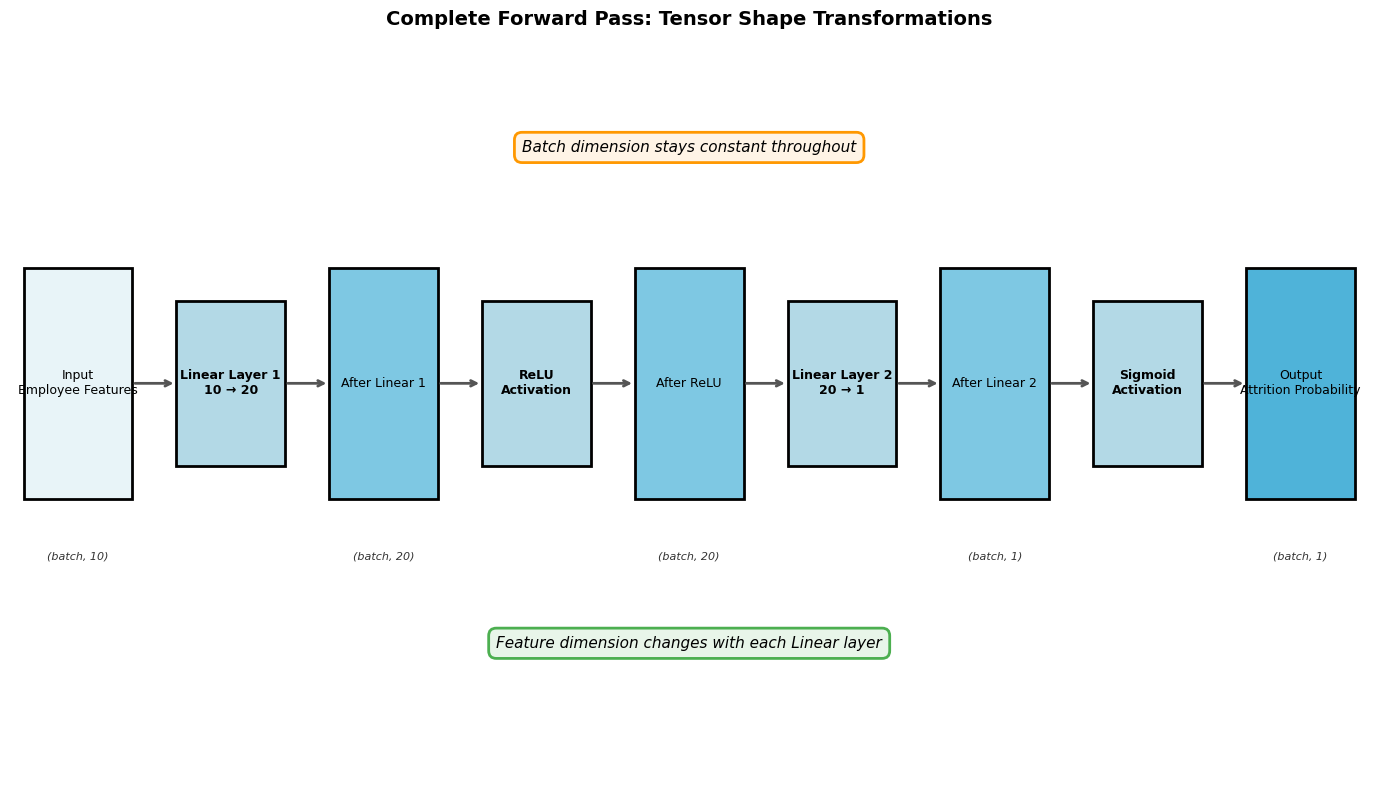


Visualization saved! This diagram shows exactly what happens during model(x).


In [12]:
# Create a visual representation of the data flow
fig, ax = plt.subplots(figsize=(14, 8))

# Define the stages and their shapes
stages = [
    {'name': 'Input\nEmployee Features', 'shape': '(batch, 10)', 'color': '#e8f4f8'},
    {'name': 'Linear Layer 1\n10 → 20', 'shape': '', 'color': '#b3d9e6'},
    {'name': 'After Linear 1', 'shape': '(batch, 20)', 'color': '#7ec8e3'},
    {'name': 'ReLU\nActivation', 'shape': '', 'color': '#b3d9e6'},
    {'name': 'After ReLU', 'shape': '(batch, 20)', 'color': '#7ec8e3'},
    {'name': 'Linear Layer 2\n20 → 1', 'shape': '', 'color': '#b3d9e6'},
    {'name': 'After Linear 2', 'shape': '(batch, 1)', 'color': '#7ec8e3'},
    {'name': 'Sigmoid\nActivation', 'shape': '', 'color': '#b3d9e6'},
    {'name': 'Output\nAttrition Probability', 'shape': '(batch, 1)', 'color': '#4fb3d9'},
]

# Draw boxes and arrows
x_positions = np.linspace(0.5, 9.5, len(stages))
y_position = 0.5
box_width = 0.8
box_height = 0.35

for i, (x, stage) in enumerate(zip(x_positions, stages)):
    # Determine box size based on whether it's a layer or a tensor state
    is_operation = stage['shape'] == ''
    height = 0.25 if is_operation else box_height
    
    # Draw box
    rect = plt.Rectangle((x - box_width/2, y_position - height/2), 
                         box_width, height,
                         facecolor=stage['color'], 
                         edgecolor='black', 
                         linewidth=2)
    ax.add_patch(rect)
    
    # Add text
    ax.text(x, y_position, stage['name'], 
           ha='center', va='center', 
           fontsize=9, fontweight='bold' if is_operation else 'normal')
    
    if stage['shape']:
        ax.text(x, y_position - height/2 - 0.08, stage['shape'], 
               ha='center', va='top', 
               fontsize=8, style='italic', color='#333')
    
    # Draw arrow to next stage
    if i < len(stages) - 1:
        arrow_start = x + box_width/2
        arrow_end = x_positions[i+1] - box_width/2
        ax.annotate('', xy=(arrow_end, y_position), xytext=(arrow_start, y_position),
                   arrowprops=dict(arrowstyle='->', lw=2, color='#555'))

# Add batch dimension callout
ax.text(5, 0.85, 'Batch dimension stays constant throughout', 
       ha='center', fontsize=11, style='italic', 
       bbox=dict(boxstyle='round,pad=0.5', facecolor='#fff4e6', edgecolor='#ff9800', linewidth=2))

ax.text(5, 0.1, 'Feature dimension changes with each Linear layer', 
       ha='center', fontsize=11, style='italic',
       bbox=dict(boxstyle='round,pad=0.5', facecolor='#e8f5e9', edgecolor='#4caf50', linewidth=2))

# Set plot properties
ax.set_xlim(0, 10)
ax.set_ylim(-0.1, 1)
ax.axis('off')
ax.set_title('Complete Forward Pass: Tensor Shape Transformations', 
            fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'forward_pass_flow.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nVisualization saved! This diagram shows exactly what happens during model(x).")

> **The complete picture**: This visualization reveals the entire forward pass. The light blue boxes are **tensor states** (the data at each step), while the darker boxes are **operations** (the transformations). Notice:
> - Linear layers **change** the feature dimension (10→20, then 20→1)
> - Activation functions **preserve** the shape while transforming values
> - The batch dimension **never changes**—it represents how many examples flow through in parallel
> 
> Every neural network, no matter how complex, is just a longer version of this pattern: alternating between linear transformations that change dimensions and non-linear activations that transform values.

## Conclusion

Congratulations! You've learned how to take full control of the forward pass in PyTorch.

**What you've learned:**

- [x] **The `nn.Module` blueprint**: Every custom network needs `__init__()` to define layers and `forward()` to define data flow
- [x] **How to implement `forward()`**: Specify exactly how data moves through your network, step by step
- [x] **How `model(x)` works**: It's a convenient shortcut that calls `model.forward(x)` plus important background operations
- [x] **Why custom matters**: You can build any architecture you can imagine, and full control over the process!

> **Key insight**: nn.Sequential` is convenient for simple linear architectures, but implementing `forward()` yourself gives you complete flexibility. Subclassing `nn.Module` and implementing `forward()` is your gateway to building any neural network architecture you can conceive.

##### Next steps to explore:

- [ ] **Why is it not recommented to call `forward()` directly?** You've learned that `model(x)` calls `forward(x)` behind the scenes. But what critical PyTorch bookkeeping happens in between? What would break if you bypassed `model(x)` and called `model.forward(x)` directly?
<br>_[Learn about the `__call__()` method: it handles training/eval mode switching, gradient tracking, and hook execution that `forward()` alone doesn't manage!]]_
<br><br>
- [ ] **What if PyTorch doesn't have the layer you need?** You've subclassed `nn.Module` to build networks from existing layers. But what if you need a custom operation such as a specialized normalization, a novel attention mechanism, or a domain-specific transformation? How do you create your own layers that work seamlessly with PyTorch?
<br>_[Explore creating custom layers by subclassing `nn.Module` at the layer level!]_
<br>

---

## Appendix: What custom forward passes unlock

Once you take control of the forward pass, you’re no longer limited to the linear “layer-after-layer” flow enforced by `nn.Sequential`.
A custom `forward()` lets you express architectural patterns that define modern deep learning—patterns that depend on branching, skipping, conditioning, or exposing intermediate results.

These patterns are exactly what make today’s architectures possible: ResNets, Transformers, GANs, Diffusion Models, and many others.

In practice, gaining control of the forward pass unlocks four essential capabilities:

### 1. Access Intermediate Representations
**Definition:** Extract and return feature maps from any layer for visualization, analysis, or auxiliary tasks.

**Example:**
```python
def forward(self, x):
    x = self.layer1(x)
    intermediate = x.clone()  # Save for visualization/analysis
    x = torch.relu(x)
    ...
    return output, intermediate
```

**Use cases:** Feature visualization, transfer learning, multi-task learning
**Learn more:** [PyTorch Hooks Documentation](https://pytorch.org/docs/stable/notes/modules.html#forward-and-backward-hooks)

### 2. Skip Connections (Residual Networks)
**Definition:** Add direct pathways that allow gradients and information to bypass layers, enabling very deep networks.

**Example:**
```python
def forward(self, x):
    identity = x  # Save input
    x = self.layer1(x)
    x = torch.relu(x)
    x = x + identity  # Add skip connection
    ...
```

**Use cases:** ResNets, U-Nets, DenseNets—any architecture requiring depth without vanishing gradients
**Learn more:** [Deep Residual Learning Paper](https://arxiv.org/abs/1512.03385)

### 3. Conditional Logic
**Definition:** Apply different operations based on runtime conditions like training mode, batch size, or input properties.

**Example:**
```python
def forward(self, x):
    x = self.layer1(x)
    if self.training:  # Only during training
        x = self.dropout(x)
    ...
```

**Use cases:** Dropout during training only, different behavior for inference, dynamic architecture adjustments
**Learn more:** [PyTorch Control Flow](https://docs.pytorch.org/docs/stable/cond.html)

### 4. Multiple Paths (Branching)
**Definition:** Split data into parallel processing streams and recombine them, enabling multi-scale or multi-modal learning.

**Example:**
```python
def forward(self, x):
    path1 = self.branch1(x)
    path2 = self.branch2(x)
    x = torch.cat([path1, path2], dim=1)  # Combine paths
    ...
```

**Use cases:** Inception modules, multi-scale feature extraction, ensemble architectures
**Learn more:** [Inception Architecture Paper](https://arxiv.org/abs/1409.4842)

---